In [ ]:
"""
created by:
Nick Roseveare, Nov 2018, nicholasroseveare AT gmail.com
"""

## NOTES
Looking at this reference on EEG: https://en.wikipedia.org/wiki/Electroencephalography
a cursory review shows that Beta and Gamma waves 16-32Hz, and >32Hz are most related to active thinking, and even short-term memory/pattern matching tasks.

## Feature analysis ideas
   * Based on the above we could try taking coefficients from a FFT or power spectral density
   * Since there are a lot of possible native 'features', we might try a data reduction technique like PCA to exact combinations of feature that correspond to 'designed' features that contain more relevant information about the underlying signal
   * Similarly, we can use correlation analysis (and/or PCA) to find features correlated for one group that are more or less uncorrelated for the other group, thus, keeping these specific pairs should provide some discriminating features
   * Along with a reduction in the features considered useful, we can try a naive Bayes with a few moment statistics as inputs 
   * Leaning toward PCA-reduced or correlation-based sub-selection of frequency/PSD features from individual sensors combined via PCA dominant eigen-vectors; 
   * Can also try with manually selected frequency features based on Gamma and Beta wave frequencies
   * create encoder for one-hot on the match types (or just create three models), use 'alcoholic' or 'subject' as label


In [1]:
from eeg_project.read_data import (import_eeg_file, GetClassId,
    my_read_eeg_generic, senlist_known, match_types, SAMP_FREQ,
    accumulate_subject_file_list, PSD_on_row_data, pass_through, zero, PSD_on_row_data, fft_on_row_data,
    eeg_half_half_alcoholic_all_subjects_obj_40, eeg_half_half_alcoholic_all_subjects_obj_100,
    eeg_half_half_alcoholic_all_subjects_match_100, eeg_half_half_alcoholic_all_subjects_nomatch_100,
    get_all_metadata, sample_file_list, get_blocked_data)
from eeg_project.plot_data import (plot_data_subject_dirs, highlight_correlated_feature_twoclass)
from sklearn.metrics import accuracy_score, f1_score, make_scorer

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
import os

from six import text_type
import gzip, bz2
import tqdm 
from collections import defaultdict
import warnings

from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
# import ipywidgets as widgets
from IPython.display import display, clear_output

data_dir = 'small_data_set'
data_dirs = [f'./{data_dir}/SMNI_CMI_TRAIN', f'./{data_dir}/SMNI_CMI_TEST']

  1%|          | 1/100 [00:00<00:12,  8.23it/s]

getting example data for match_type[match] and is_alcoholic[True]


  1%|          | 1/100 [00:00<00:11,  8.37it/s]

getting example data for match_type[match] and is_alcoholic[False]


100%|██████████| 100/100 [00:12<00:00,  8.09it/s]


SVec size (64, 64)


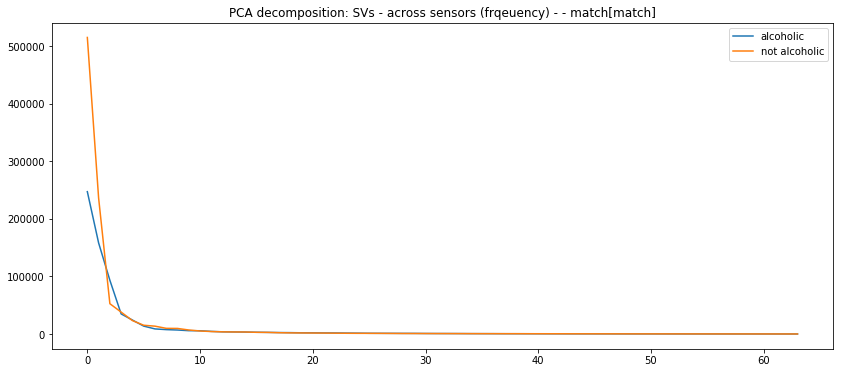

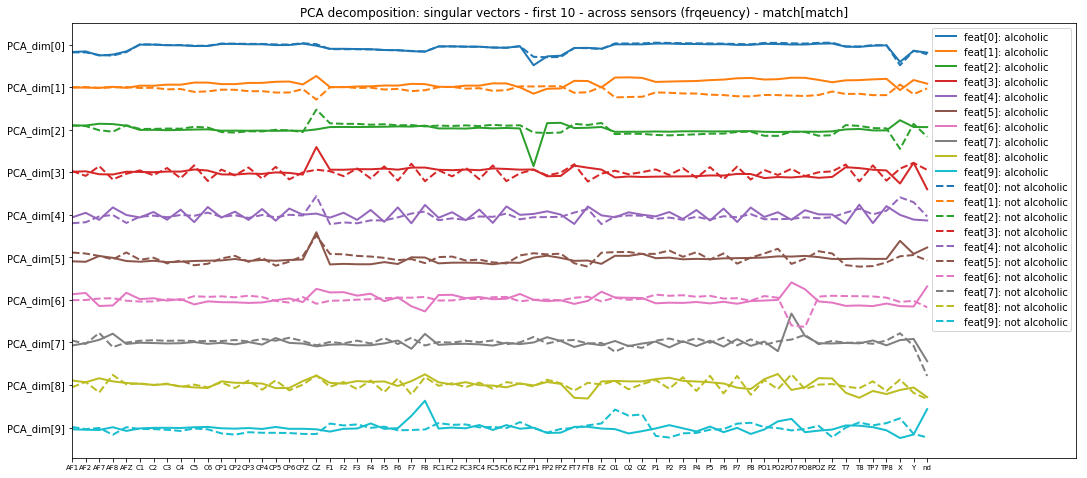

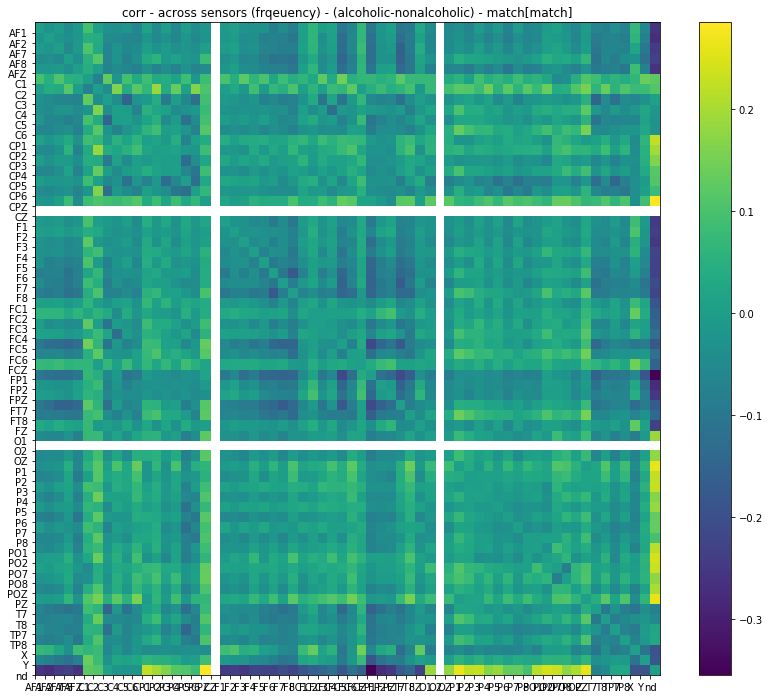

In [2]:
Ua, Una = highlight_correlated_feature_twoclass(
    100, 
    process_data=fft_on_row_data,
    pca_vec_to_plot=10,
    match_types_in=['match'], figsize=(14, 12), debug=1)

  0%|          | 1/200 [00:00<00:27,  7.16it/s]

getting example data for match_type[nomatch] and is_alcoholic[True]


  0%|          | 1/200 [00:00<00:24,  8.24it/s]

getting example data for match_type[nomatch] and is_alcoholic[False]


100%|██████████| 200/200 [00:25<00:00,  7.96it/s]


SVec size (64, 64)


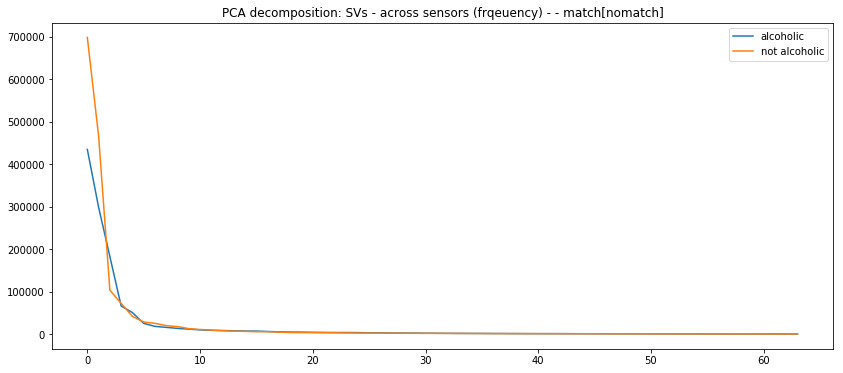

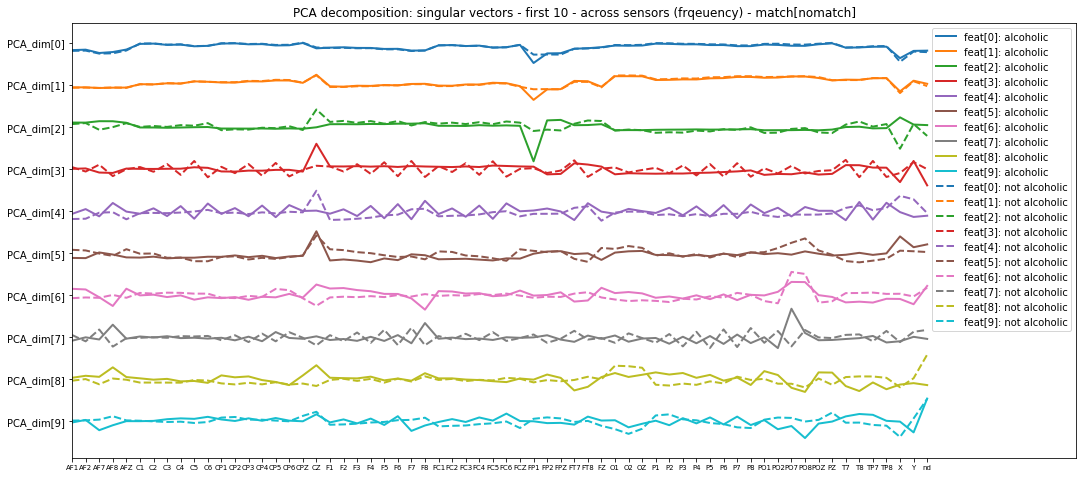

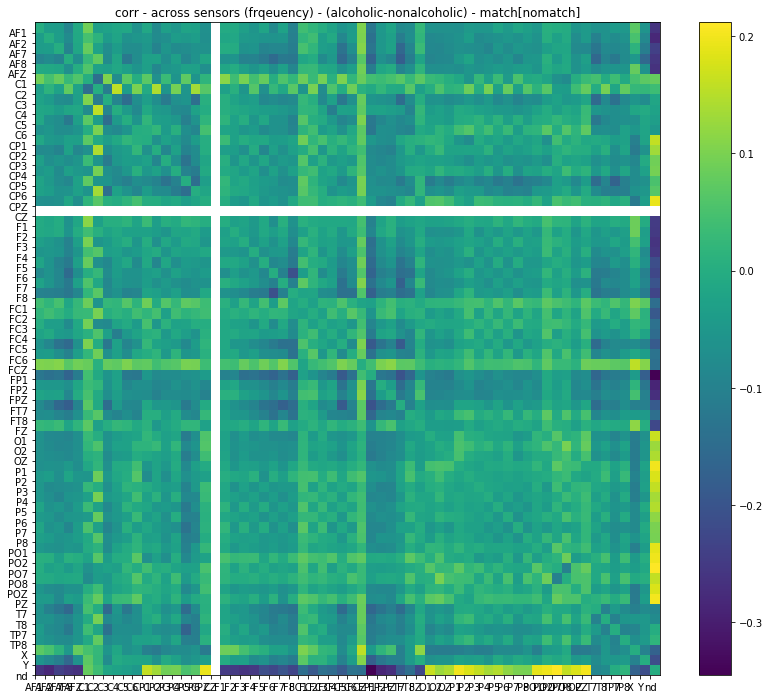

In [55]:
Ua_nm, Una_nm = highlight_correlated_feature_twoclass(
    200, 
    process_data=fft_on_row_data,
    pca_vec_to_plot=10,
    match_types_in=['nomatch'], figsize=(14, 12), debug=1)

  0%|          | 1/200 [00:00<00:27,  7.17it/s]

getting example data for match_type[obj] and is_alcoholic[True]


  0%|          | 1/200 [00:00<00:23,  8.34it/s]

getting example data for match_type[obj] and is_alcoholic[False]


100%|██████████| 200/200 [00:25<00:00,  7.90it/s]


SVec size (64, 64)


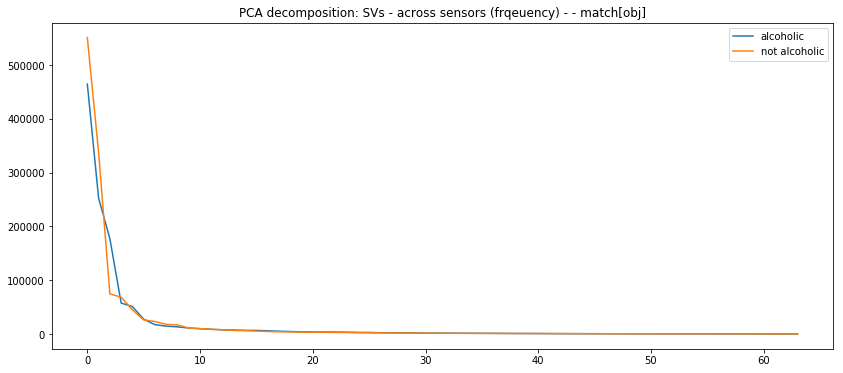

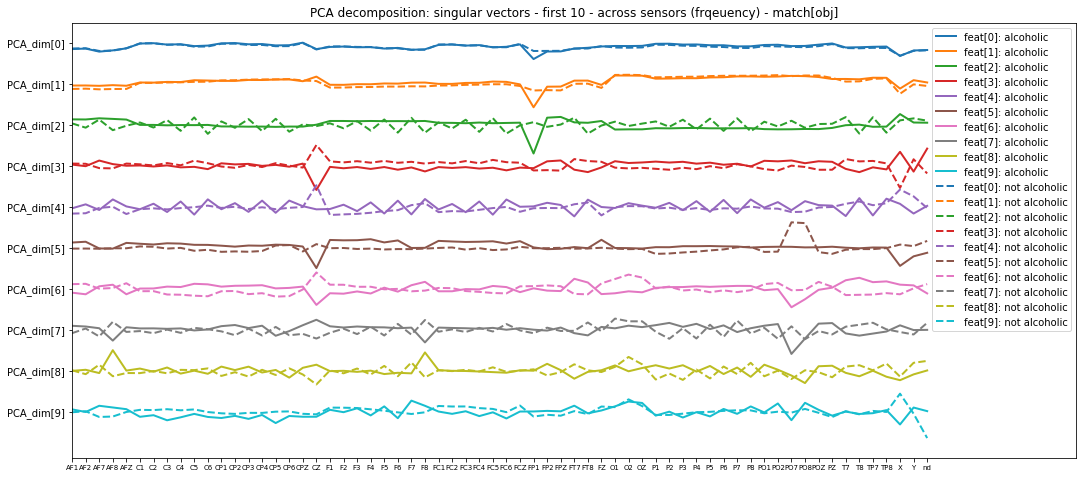

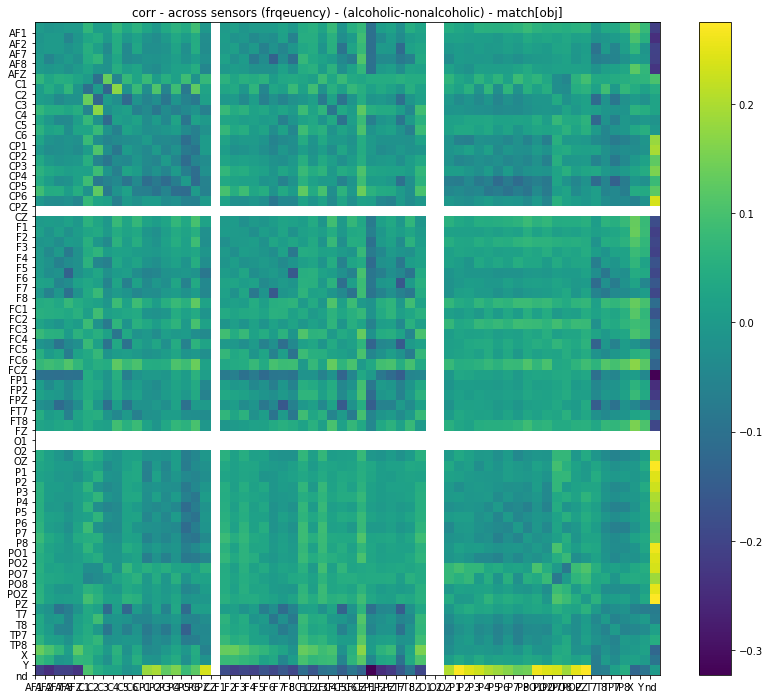

In [56]:
Ua_o, Una_o = highlight_correlated_feature_twoclass(
    200, 
    process_data=fft_on_row_data,
    pca_vec_to_plot=10,
    match_types_in=['obj'], figsize=(14, 12), debug=1)

In [58]:
use_onehost_categorical_feats, freq_data, multi_subject_id = False, True, False

name_suffix = ''
if multi_subject_id:
    name_suffix += '.multiclass'
if use_onehost_categorical_feats:
    name_suffix += '.onehot_catfeats'
if freq_data:
    name_suffix += '.fft'

data_tuple = get_blocked_data(#file_list, 
    use_onehot_cat_feat=use_onehost_categorical_feats,
    multiclass=multi_subject_id,
    process_data=(fft_on_row_data if freq_data else pass_through), 
    pickle_name=f'eeg_all_data_medium_size_1200{name_suffix}.bin')

if len(data_tuple) > 5:
    multi_class = True
    X_train, y_train, X_test, y_test, uses_cat_feat, classIdDict = data_tuple
else:
    X_train, y_train, X_test, y_test, uses_cat_feat = data_tuple
    
X_train, X_test = X_train.numpy(), X_test.numpy()
y_train, y_test = y_train.numpy(), y_test.numpy()

reading binary of organized data from:
   ./eeg_ML/eeg_all_data_medium_size_1200.fft.bin

   Xtrain:torch.Size([600, 1, 256, 64])
   ytrain:torch.Size([600])
   Xtest:torch.Size([600, 1, 256, 64])
   ytest:torch.Size([600])
   use 1-hot categorical feats: False


(600, 1, 256, 64)
accurracy: 0.71|0.71, F-1: 0.6741573033707865|0.6753731343283581


<IPython.core.display.Javascript object>


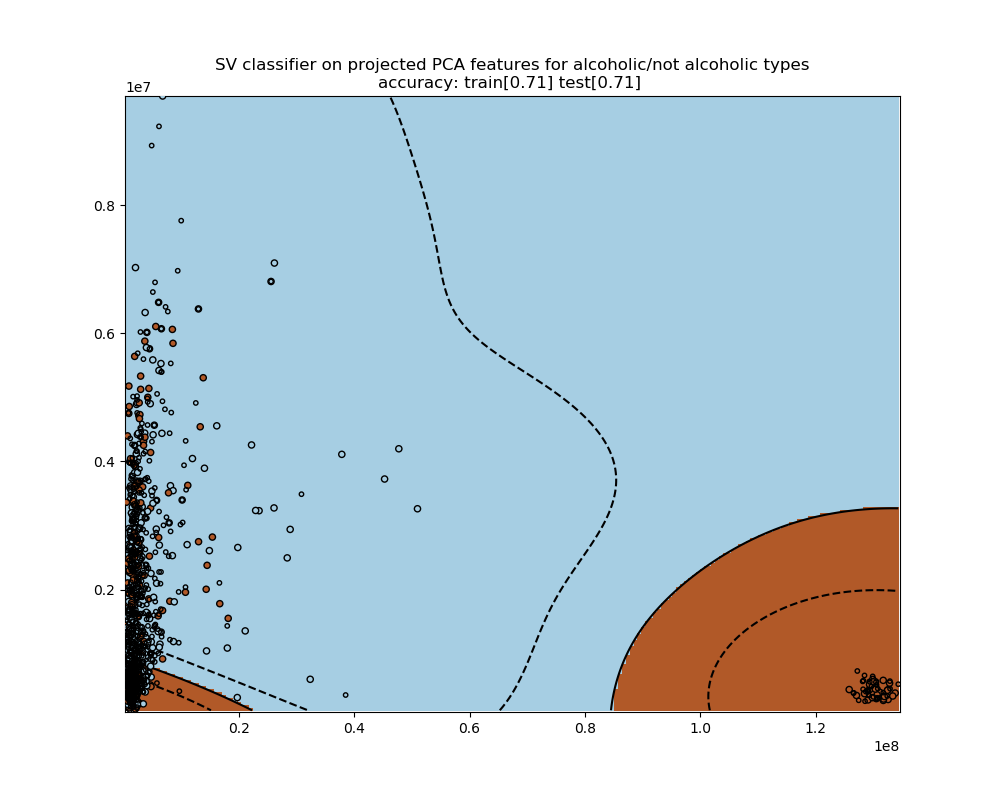

In [129]:
%matplotlib notebook

# try a two-feature version relying only on the 
clf = SVC(C=.7, cache_size=200, class_weight=None, coef0=0.0,
    gamma='scale', kernel='rbf', max_iter=2000, tol=0.0001,
    probability=False, random_state=None, shrinking=True)

# for two-feature case, try extracting different features
# feature_extract = np.concatenate([Ua[:, 2:3], Una[:, 2:3]], axis=1)
feature_extract = np.concatenate([Ua[:, 2:3], Una_o[:, 5:6]], axis=1)
# feature_extract = np.concatenate([Ua[:, 2:3], Una_nm[:, 7:8]], axis=1)
# feature_extract = np.concatenate([Ua[:, 2:3], Ua[:, 8:9]], axis=1)

feature_extract_T = feature_extract.transpose()
feat_dim = feature_extract.shape[1]

Xtrain_fmapped = np.zeros((X_train.shape[0], feat_dim))
Xtest_fmapped = np.zeros((X_test.shape[0], feat_dim))
print(X_train.shape)
for i in range(Xtrain_fmapped.shape[0]):
    XX = X_train[i, 0, :, :].reshape(X_train.shape[2], X_train.shape[3])
    XX = np.matmul(XX.transpose(), XX)
    Xtrain_fmapped[i, :] = np.diag(np.matmul(np.matmul(feature_extract_T, XX), feature_extract))
for i in range(Xtest_fmapped.shape[0]):
    XX = X_test[i, 0, :, :].reshape(X_test.shape[2], X_test.shape[3])
    XX = np.matmul(XX.transpose(), XX)
    Xtest_fmapped[i, :] = np.diag(np.matmul(np.matmul(feature_extract_T, XX), feature_extract))

                                                  
scaler = StandardScaler().fit(Xtrain_fmapped)

min_max = np.matrix([np.min(Xtest_fmapped, axis=0), np.max(Xtest_fmapped, axis=0)])
# print(min_max)                             
                                                                          
clf.fit(scaler.transform(Xtrain_fmapped), y_train)
pred_tr = clf.predict(scaler.transform(Xtrain_fmapped))
pred = clf.predict(scaler.transform(Xtest_fmapped))

tr_acc, tst_acc = accuracy_score(pred_tr, y_train), accuracy_score(pred, y_test)
print(f'accurracy: {tr_acc}|{tst_acc},'
      f' F-1: {f1_score(pred_tr, y_train)}|{f1_score(pred, y_test)}')


pyplot.figure(figsize=(10, 8))
pyplot.clf()
pyplot.scatter(Xtrain_fmapped[:, 0], Xtrain_fmapped[:, 1], 
    c=y_train, zorder=10, cmap=pyplot.cm.Paired, edgecolor='k', s=20)

# highlight out the test data
pyplot.scatter(Xtest_fmapped[:, 0], Xtest_fmapped[:, 1], # marker='x', 
    s=10, 
    facecolors='none', zorder=10, edgecolor='k')

x_min = min(Xtrain_fmapped[:, 0].min(), Xtest_fmapped[:, 0].min())
x_max = max(Xtrain_fmapped[:, 0].max(), Xtest_fmapped[:, 0].max())
y_min = min(Xtrain_fmapped[:, 1].min(), Xtest_fmapped[:, 1].min())
y_max = max(Xtrain_fmapped[:, 1].max(), Xtest_fmapped[:, 1].max())

XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]

scaled_ravel = scaler.transform(np.concatenate([
    np.matrix(XX.ravel()).transpose(), 
    np.matrix(YY.ravel()).transpose()], axis=1))
# print(scaled_ravel)

Z = clf.decision_function(np.c_[scaled_ravel])

# Put the result into a color plot
Z = Z.reshape(XX.shape) # + max(0, np.min(Z))

pyplot.pcolormesh(XX, YY, Z > 0, 
                cmap=pyplot.cm.Paired)
pyplot.contour(XX, YY, Z, colors=['k', 'k', 'k'],
            linestyles=['--', '-', '--'], levels=[-.5, 0, .5])

pyplot.title('SV classifier on projected PCA features for alcoholic/not alcoholic types\n'
             f'accuracy: train[{tr_acc}] test[{tst_acc}] ')
# pyplot.axis('tight')
pyplot.autoscale(tight=True)
pyplot.show()

In [128]:
# check that our parameters of choice are fairly reasonable

# NOTE: it is not best practice to use your final test set for hyper-parameter tuning 
# and validation, incestuous way to do controlled testing
from sklearn.model_selection import GridSearchCV

clf = SVC(C=0.7, cache_size=200, class_weight=None, coef0=0.0,
    gamma='scale', kernel='rbf', max_iter=3000, tol=0.0001,
    probability=False, random_state=None, shrinking=True)

parameters = {'kernel': ['poly', 'linear', 'rbf'],
              'C':np.arange(0.1, 1.5, 0.1), 
              'gamma': ['scale', 'auto']}

clf = GridSearchCV(clf, parameters, cv=None, scoring=make_scorer(f1_score))
with warnings.catch_warnings(record=True):
    # Cause all warnings to always be triggered.
    warnings.simplefilter("ignore")
    clf.fit(Xtrain_fmapped, y_train)

#  clf = svm.SVC(kernel=kernel, gamma=10)
#     clf.fit(X_train, y_train)
    max_ind = np.argsort(np.asarray(clf.cv_results_['rank_test_score']))
    print(f'top three parameter settings: {max_ind[:3]}')
    for ind in max_ind[:3]:
        print(f"   rank:{clf.cv_results_['rank_test_score'][ind]}, ")
        print(f"   train:{clf.cv_results_['mean_train_score'][ind]:.3f}"
            f"+/-{clf.cv_results_['std_train_score'][ind]:.3f} ")
        print(f"   test:{clf.cv_results_['mean_test_score'][ind]:.3f}"
            f"+/-{clf.cv_results_['std_test_score'][ind]:.3f}")
        
        print('      ' + f"{clf.cv_results_['params'][ind]}")
#                                         for k in clf.cv_results_.keys() if 'param' in k])) # and k != ]))
#         print('      ' + ', '.join([f"{k}:{clf.cv_results_[k][ind]}" 
#                                         for k in clf.cv_results_.keys() if 'param' in k and k != 'params']))


top three parameter settings: [41 77 71]
   rank:1, 
   train:1.000+/-0.000 
   test:0.667+/-0.000
      {'C': 0.7000000000000001, 'gamma': 'auto', 'kernel': 'rbf'}
   rank:1, 
   train:1.000+/-0.000 
   test:0.667+/-0.000
      {'C': 1.3000000000000003, 'gamma': 'auto', 'kernel': 'rbf'}
   rank:1, 
   train:1.000+/-0.000 
   test:0.667+/-0.000
      {'C': 1.2000000000000002, 'gamma': 'auto', 'kernel': 'rbf'}


In [8]:
# just perform a fit on all the vectorized data directly (no feature selection)
X_train = X_train.reshape(
        (X_train.shape[0], (X_train.shape[2] * X_train.shape[3])))
X_test = X_test.reshape(
        (X_test.shape[0], (X_test.shape[2] * X_test.shape[3])))

scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

clf.fit(X_train, y_train) 


# pred = clf.predict(scaler.transform(Xtest_fmapped))
pred_tr = clf.predict(X_train)
pred = clf.predict(X_test)

print(f'accurracy: {accuracy_score(pred_tr, y_train)}|{accuracy_score(pred, y_test)},'
      f' F-1: {f1_score(pred_tr, y_train)}|{f1_score(pred, y_test)}')

accurracy: 0.96|0.6633333333333333, F-1: 0.9606557377049181|0.6720779220779222


In [16]:
from sklearn.model_selection import GridSearchCV

parameters = {'C':[0.2, 0.5, 1.2], 'gamma': ['scale', 'auto']}

clf = GridSearchCV(clf, parameters, cv=None, scoring=make_scorer(f1_score))

clf.fit(X_train, y_train)

/Users/nick/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv=None, error_score='raise-deprecating',
       estimator=SVC(C=0.7, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=1000, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.2, 0.5, 1.2], 'gamma': ['scale', 'auto']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(f1_score), verbose=0)

In [2]:
# subject_data = pd.DataFrame({})
# frame_list = []
# for file in half_half_alcoholic_all_subjects_40:
#     frame, info = my_read_eeg_generic(file, orig_tt_indic=('test' in file))
# #     frame = pd.read_csv(file, names=columns)
#     frame_list.append(frame)
    
# subject_data = pd.concat(frame_list, axis=0, join_axes=[frame.index, frame.columns])  # , ignore_index=True)
                                  
# subject_data